In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchvision

In [7]:
import json
import numpy as np
import pickle
import random
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import ConcatDataset, DataLoader, Subset
from base_model import BaseModel
from datasets import get_dataset

device = f"cuda:0"
dataset_name = "cifar10"
model_name = "densenet121"
input_dim = 3
batch_size = 128
num_cls = 10
pruner_name = "l1unstructure"
prune_sparsity = 0.7
shadow_model_num = 1
defend = ""
defend_arg = 4

prune_prefix = f"{pruner_name}_{prune_sparsity}{'_' + defend if defend else ''}{'_' + str(defend_arg) if defend else ''}"

save_folder = f"results/{dataset_name}_{model_name}"

# Load datasets
trainset = get_dataset(dataset_name, train=True)
testset = get_dataset(dataset_name, train=False)
if testset is None:
    total_dataset = trainset
else:
    total_dataset = ConcatDataset([trainset, testset])
total_size = len(total_dataset)
data_path = f"{save_folder}/data_index.pkl"
with open(data_path, 'rb') as f:
    victim_train_list, victim_dev_list, victim_test_list, attack_split_list \
        = pickle.load(f)
victim_train_dataset = Subset(total_dataset, victim_train_list)
victim_test_dataset = Subset(total_dataset, victim_test_list)
print(f"Total Data Size: {total_size}, "
      f"Victim Train Size: {len(victim_train_list)}, "
      f"Victim Test Size: {len(victim_test_list)}")
victim_train_loader = DataLoader(victim_train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)
victim_test_loader = DataLoader(victim_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)

# Load pruned victim model
victim_model_save_folder = save_folder + "/victim_model"
victim_model_path = f"{victim_model_save_folder}/best.pth"
victim_model = BaseModel(model_name, num_cls=num_cls, input_dim=input_dim, device=device)
victim_model.load(victim_model_path, verbose=False)

pruned_model_save_folder = f"{save_folder}/{prune_prefix}_model"
print(f"Load Pruned Model from {pruned_model_save_folder}")
victim_pruned_model = BaseModel(model_name, num_cls=num_cls, input_dim=input_dim, save_folder=pruned_model_save_folder, device=device)
victim_pruned_model.model.load_state_dict(torch.load(f"{pruned_model_save_folder}/best.pth"))

Build Dataset cifar10
Files already downloaded and verified
Build Dataset cifar10
Files already downloaded and verified
Total Data Size: 60000, Victim Train Size: 13500, Victim Test Size: 13500
Build Model densenet121 Parameter Number: 6956K
Load Pruned Model from results_ens/cifar10_densenet121_es/level_0.7_model
Build Model densenet121 Parameter Number: 6956K


<All keys matched successfully>

In [8]:
small_victim_in_predicts, victim_in_targets, small_victim_in_sens = victim_pruned_model.predict_target_sensitivity(victim_train_loader)
small_victim_out_predicts, victim_out_targets, small_victim_out_sens = victim_pruned_model.predict_target_sensitivity(victim_test_loader)
big_victim_in_predicts, _, big_victim_in_sens = victim_model.predict_target_sensitivity(victim_train_loader)
big_victim_out_predicts, _, big_victim_out_sens = victim_model.predict_target_sensitivity(victim_test_loader)

# Original Model Confidence

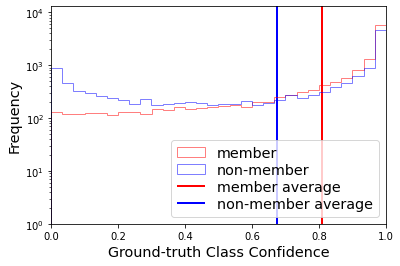

In [10]:
data_in = big_victim_in_predicts[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = big_victim_out_predicts[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')
plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Confidence", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
plt.xlim([0, 1.0])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

# Pruned Model Confidence

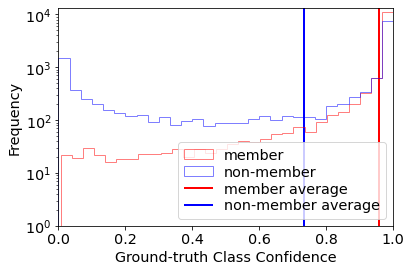

In [12]:
data_in = small_victim_in_predicts[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = small_victim_out_predicts[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')

plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Confidence", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
plt.xlim([0, 1.0])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

# Original Model Sensitivity

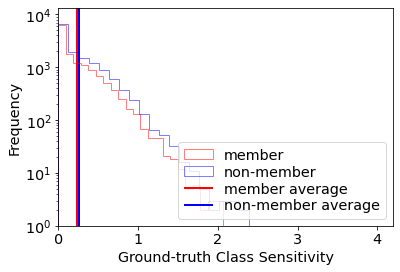

In [14]:
data_in = big_victim_in_sens[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = big_victim_out_sens[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')

plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Sensitivity", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
# plt.autoscale(tight=True)
plt.xlim([0, 4.2])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

# Pruned Model Sensitivity

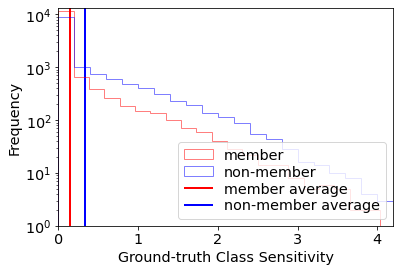

In [16]:
data_in = small_victim_in_sens[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = small_victim_out_sens[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')

plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Sensitivity", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
# plt.autoscale(tight=True)
plt.xlim([0, 4.2])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

In [17]:
def prec2(predicts, targets):
    a = [[] for _ in range(num_cls)]
    for i in range(predicts.size(0)):
        a[targets[i]].append(predicts[i, targets[i]])
    b = [np.mean(x) for x in a]
    return np.array(b)

data1 = prec2(big_victim_in_predicts, victim_in_targets)
data2 = prec2(big_victim_out_predicts, victim_out_targets)
data3 = prec2(small_victim_in_predicts, victim_in_targets)
data4 = prec2(small_victim_out_predicts, victim_out_targets)

# Original model confidence over different classes

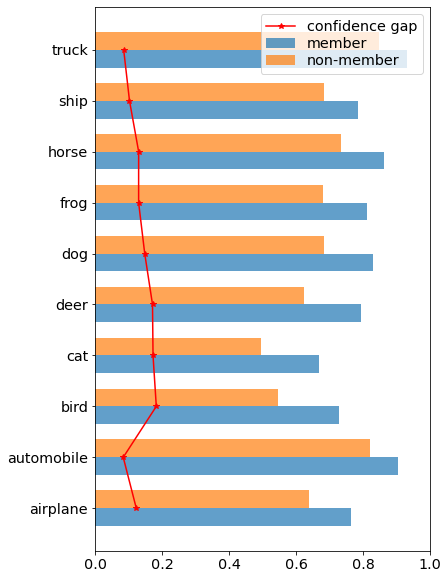

In [19]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data1[new_indices]
tmp2_new = data2[new_indices]

dataset = torchvision.datasets.CIFAR10(root='/data/datasets/cifar10-data', train=False, download=False)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp1_new - tmp2_new, labels, '*-', c='r', label="confidence gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([0,1])
plt.show()

# Pruned model confidence over different classes

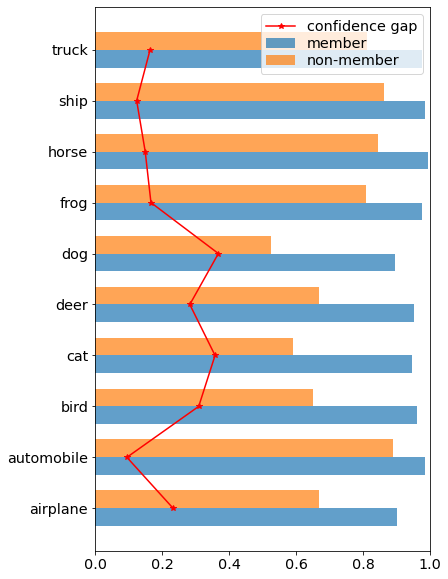

In [21]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data3[new_indices]
tmp2_new = data4[new_indices]

dataset = torchvision.datasets.CIFAR10(root='/data/datasets/cifar10-data', train=False, download=False)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp1_new - tmp2_new, labels, '*-', c='r', label="confidence gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([0,1])
plt.show()

In [22]:
data1 = prec2(big_victim_in_sens, victim_in_targets)
data2 = prec2(big_victim_out_sens, victim_out_targets)
data3 = prec2(small_victim_in_sens, victim_in_targets)
data4 = prec2(small_victim_out_sens, victim_out_targets)

# Original Model Sensitivity over different classes

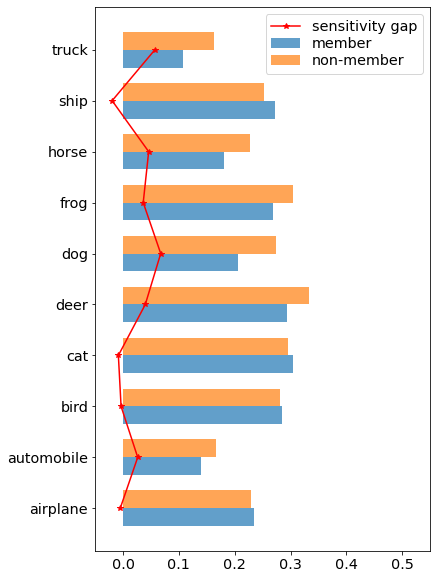

In [24]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data1[new_indices]
tmp2_new = data2[new_indices]

dataset = torchvision.datasets.CIFAR10(root='/data/datasets/cifar10-data', train=False, download=False)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp2_new - tmp1_new, labels, '*-', c='r', label="sensitivity gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([-0.05,0.55])
plt.show()

# Pruned Model Sensitivity over different classes

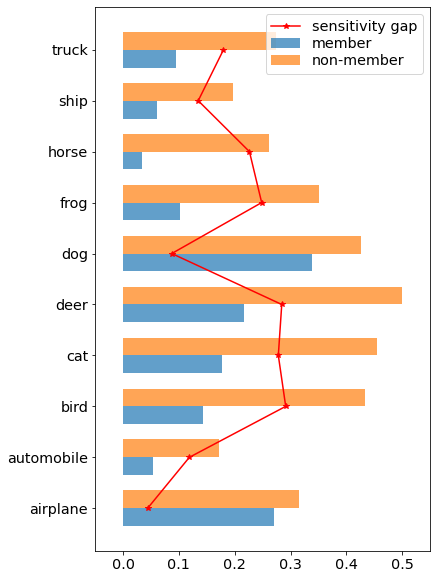

In [26]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data3[new_indices]
tmp2_new = data4[new_indices]

dataset = torchvision.datasets.CIFAR10(root='/data/datasets/cifar10-data', train=False, download=False)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp2_new - tmp1_new, labels, '*-', c='r', label="sensitivity gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([-0.05,0.55])
plt.show()